In [1]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

In [2]:
df = pd.read_parquet('data/BTCUSDT_2017-08-17 04:00:00_2023-04-17 00:00:00.parquet', engine='pyarrow')

# sort data raw by timestamp
df.sort_values(by='time', inplace=True)

Basic EDA

In [3]:
print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')

print(f'First timestamp: {df.time.iloc[0]}')
print(f'Last timestamp: {df.time.iloc[-1]}')

cols = df.columns
cols

Number of rows: 2970432
Number of columns: 11
First timestamp: 2017-08-17 04:00:00
Last timestamp: 2023-04-16 23:03:00


Index(['time', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume'],
      dtype='object')

In [4]:
df.head(1)

,time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183,2017-08-17 04:00:59.999,7564.906851,3,0.075183,320.390851


In [5]:
df.tail(1)

,time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
2970431,2023-04-16 23:03:00,30324.35,30338.56,30324.34,30338.56,8.42399,2023-04-16 23:03:59.999,255489.767588,268,8.07428,244881.35598


In [6]:
df.describe()

,time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
count,2970432,2.970432e+06,2.970432e+06,2.970432e+06,2.970432e+06,2.970432e+06,2970432,2.970432e+06,2.970432e+06,2.970432e+06,2.970432e+06
mean,2020-06-17 20:26:41.613488640,1.965622e+04,1.966924e+04,1.964309e+04,1.965621e+04,5.414251e+01,2020-06-17 20:27:41.612317184,1.172821e+06,1.038013e+03,2.695525e+01,5.815623e+05
min,2017-08-17 04:00:00,2.830000e+03,2.830000e+03,2.817000e+03,2.817000e+03,0.000000e+00,2017-08-17 04:00:59.999000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2019-01-18 00:08:45,7.440000e+03,7.444000e+03,7.435958e+03,7.440000e+03,1.146194e+01,2019-01-18 00:09:44.999000064,1.077324e+05,1.430000e+02,5.270170e+00,5.030207e+04
50%,2020-06-18 09:52:30,1.117856e+04,1.118921e+04,1.116685e+04,1.117834e+04,2.443774e+01,2020-06-18 09:53:29.999000064,3.636709e+05,4.090000e+02,1.178840e+01,1.738230e+05
75%,2021-11-17 04:55:15,2.972198e+04,2.973620e+04,2.970882e+04,2.972208e+04,5.550401e+01,2021-11-17 04:56:14.999000064,1.308063e+06,1.057000e+03,2.768937e+01,6.355100e+05
max,2023-04-16 23:03:00,6.900000e+04,6.900000e+04,6.878670e+04,6.900000e+04,5.877775e+03,2023-04-16 23:03:59.999000,1.459557e+08,1.073150e+05,3.537453e+03,8.947551e+07
std,NaN,1.634856e+04,1.635938e+04,1.633780e+04,1.634857e+04,9.933078e+01,NaN,2.368206e+06,1.851644e+03,5.053294e+01,1.209554e+06


<Axes: xlabel='time'>

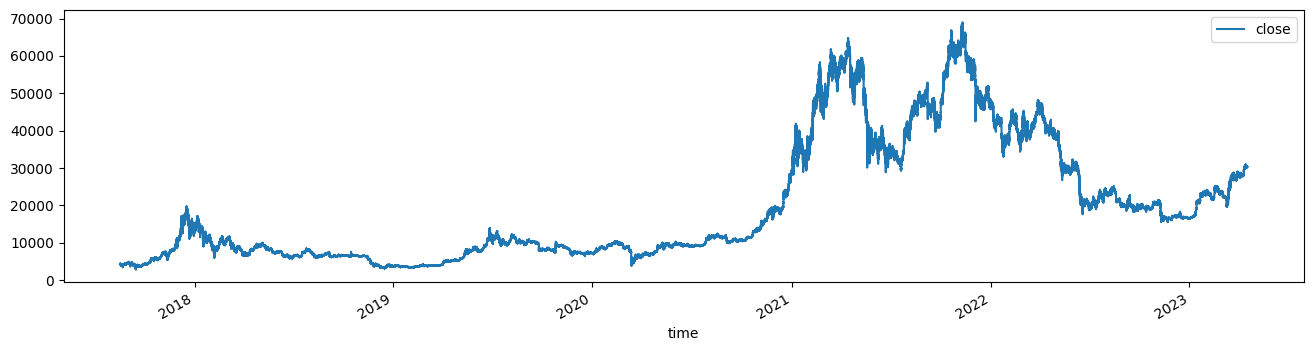

In [7]:
# line plot of close value over time
df.plot(x='time', y='close', figsize=(16,4))

Check for missing or incorrect data

In [8]:
# gaps in candlesticks

# add time diff between neighboring candlesticks to detect gaps
df_gaps = df.copy()
df_gaps["time_diff"] = df_gaps["time"].shift(-1) - df_gaps["time"]
df_gaps = df_gaps[(df_gaps["time_diff"] != "0 days 00:01:00") & (df_gaps["time_diff"] is not None)].dropna(subset=["time_diff"])

print("Gaps in data stats:")
pd.DataFrame({
    "min": df_gaps["time_diff"].min(),
    "max": df_gaps["time_diff"].max(),
    "sum": df_gaps["time_diff"].sum(),
    "count": df_gaps["time_diff"].count()
},  index=["value"]).T

Gaps in data stats:


,value
min,0 days 00:04:00
max,1 days 09:32:00
sum,6 days 00:27:00
count,35


Gaps in data for example from `2023-03-24 11:27:00` to `2023-03-24 14:00:00`
Data from `2023-03-24 11:27:00` until `2023-03-24 12:39:00` has all the same values, then missing data from `2023-03-24 12:39:00` until `2023-03-24 14:00:00`

In [9]:
# remove neighbouring duplicate rows, except the first occurence, based on non-time columns
not_time_cols = ['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']

# create a boolean mask to identify neighboring duplicate rows.
# This filters out periods od time when no trades were made, due to exchange being down.
# Cant use `drop_duplicates` as it would also detect duplicates across different time periods.
mask = (df[not_time_cols] == df[not_time_cols].shift()).all(axis=1)

# apply the mask and reset index
df = df[~mask].reset_index(drop=True)
df


,time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183,2017-08-17 04:00:59.999,7564.906851,3,0.075183,320.390851
1,2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000,2017-08-17 04:01:59.999,0.000000,0,0.000000,0.000000
2,2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074,2017-08-17 04:02:59.999,1117.542921,2,0.261074,1117.542921
3,2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008,2017-08-17 04:03:59.999,51.171852,3,0.012008,51.171852
4,2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796,2017-08-17 04:04:59.999,599.999338,1,0.140796,599.999338
...,...,...,...,...,...,...,...,...,...,...,...
2957981,2023-04-16 22:59:00,30330.56,30331.04,30330.56,30331.04,4.189910,2023-04-16 22:59:59.999,127083.875151,201,2.925070,88720.002584
2957982,2023-04-16 23:00:00,30331.03,30340.00,30331.03,30339.99,25.601690,2023-04-16 23:00:59.999,776627.466816,568,22.870340,693772.865414
2957983,2023-04-16 23:01:00,30339.99,30349.65,30339.69,30339.70,23.160550,2023-04-16 23:01:59.999,702791.503463,636,15.632420,474337.748039
2957984,2023-04-16 23:02:00,30339.69,30339.70,30321.00,30324.34,16.953000,2023-04-16 23:02:59.999,514184.406982,656,5.819900,176499.891533


In [10]:
# export
pq.write_table(pa.Table.from_pandas(df), "data.parquet")